# グラフフーリエ変換

GPU PyTorchの動作確認

In [22]:
import sys
import torch

print("Python：" + sys.version)
print("PyTorch：" + torch.__version__)

if torch.cuda.is_available():
    print("CUDA：" + torch.version.cuda)
    print("GPU：" + torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

Python：3.12.11 (main, Sep 26 2025, 17:05:50) [GCC 11.4.0]
PyTorch：2.8.0+cu128
CUDA：12.8
GPU：NVIDIA GeForce RTX 3060


## データの取得

- CORAネットワーク
    - 論文索引関係を表すネットワーク

### 取得したCoraデータを変換

- CoraのテストデータをPyTorchのデータ型に変換
- 変換したデータ分割する

In [34]:
from torch_geometric.datasets import Planetoid 
from torch_geometric.transforms import RandomLinkSplit

# Cora の citation ネットワーク (2,708 ノード / 5,429 エッジ)
data = Planetoid(root='/tmp', name='Cora')[0]
data.train_mask = data.val_mask = data.test_mask = None

print(f"ノード数: {data.num_nodes}, エッジ数: {data.num_edges}, ノード特徴量数: {data.num_node_features}")

ノード数: 2708, エッジ数: 10556, ノード特徴量数: 1433


### データを可視化

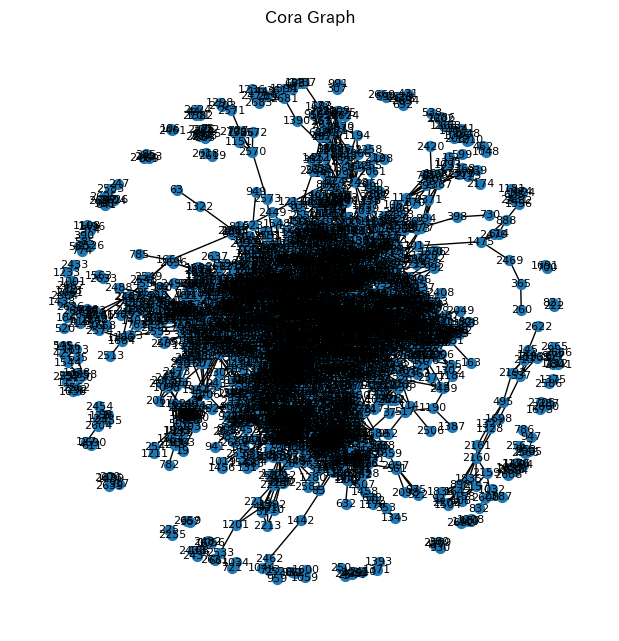

In [35]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()
G.add_edges_from(data.edge_index.t().tolist())

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)
plt.title("Cora Graph")
plt.show()

## グラフラプラシアン

### グラフラプラシアンの計算
グラフラプラシアン $L$ を計算：
- $A$: 隣接行列 (Adjacency Matrix)
- $D$: 次数行列 (Degree Matrix)
- $L = D - A$: グラフラプラシアン (Graph Laplacian)

In [43]:
import torch
import torch.nn.functional as F
from torch_geometric.utils import to_dense_adj, degree
import numpy as np

# エッジインデックスから隣接行列Aを作成
edge_index = data.edge_index
num_nodes = data.x.size(0)

# 隣接行列A (密行列として取得)
A = to_dense_adj(edge_index, max_num_nodes=num_nodes)[0]
print(f"隣接行列A の形状: {A.shape}")

# 次数行列Dを計算
# 各ノードの次数を計算
node_degrees = degree(edge_index[0], num_nodes=num_nodes)
# 次数行列D (対角行列)
D = torch.diag(node_degrees)
print(f"次数行列D の形状: {D.shape}")

# グラフラプラシアンL = D - A
L = D - A
print(f"グラフラプラシアンL の形状: {L.shape}")

隣接行列A の形状: torch.Size([2708, 2708])
次数行列D の形状: torch.Size([2708, 2708])
グラフラプラシアンL の形状: torch.Size([2708, 2708])


In [44]:
# グラフラプラシアン行列の一部を表示 (最初の5x5の部分行列)
print("隣接行列A の一部 (5x5):")
print(A[:5, :5])

print("\n次数行列D の一部 (5x5):")
print(D[:5, :5])

print("\nグラフラプラシアンL の一部 (5x5):")
print(L[:5, :5])

隣接行列A の一部 (5x5):
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

次数行列D の一部 (5x5):
tensor([[3., 0., 0., 0., 0.],
        [0., 3., 0., 0., 0.],
        [0., 0., 5., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 5.]])

グラフラプラシアンL の一部 (5x5):
tensor([[ 3.,  0.,  0.,  0.,  0.],
        [ 0.,  3., -1.,  0.,  0.],
        [ 0., -1.,  5.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  5.]])


### グラフラプラシアンの固有値分解

グラフラプラシアン $L$ の固有値分解：
```math
L = U\Lambda U^T
```

ここで：
- $U$: 固有ベクトル行列（列が固有ベクトル）
    - グラフフーリエ変換におけるフーリエ基底となる
- $\Lambda$: 固有値の対角行列
    - グラフの固有値はグラフフーリエ変換におけるグラフ周波数となる
- $U^T$: 固有ベクトル行列の転置
    - $U$は直交行列なので $U^T = U^{-1}$

In [45]:
# グラフラプラシアンの固有値分解を実行
print("=== グラフラプラシアンの固有値分解 ===")

# 固有値と固有ベクトルを計算（既に計算済みだが、明確にするため再実行）
eigenvalues, eigenvectors = torch.linalg.eigh(L)

# 固有値を昇順でソート
sorted_indices = torch.argsort(eigenvalues)
eigenvalues_sorted = eigenvalues[sorted_indices]
eigenvectors_sorted = eigenvectors[:, sorted_indices]

# U: 固有ベクトル行列
U = eigenvectors_sorted
print(f"固有ベクトル行列U の形状: {U.shape}")

# Λ (Lambda): 固有値の対角行列
Lambda = torch.diag(eigenvalues_sorted)
print(f"固有値対角行列Λ の形状: {Lambda.shape}")

=== グラフラプラシアンの固有値分解 ===
固有ベクトル行列U の形状: torch.Size([2708, 2708])
固有値対角行列Λ の形状: torch.Size([2708, 2708])


## グラフフーリエ変換

### グラフフーリエ変換の基礎

- グラフフーリエ変換 $\tilde{f}(\lambda_i)$
    - $f(k)$ : ノード $k$ におけるグラフ信号値
    - $u_i^*(k)$ : ラプラシアンの $i$ 番目の固有ベクトルの $k$ の成分
    - $\tilde{f}(\lambda_i)$ ： 固有値 $\lambda_i$ に対応する周波数成分
```math
\tilde{f}(\lambda_i) := \langle f, u_i \rangle = \sum_{k=0}^{N-1} f(k) u_i^*(k)
```

- 逆グラフフーリエ変換: $f(k)$
```math
f(k) = \sum_{i=0}^{N-1} \tilde{f}(\lambda_i) u_i(k)
```


=== グラフフーリエ変換の基礎 ===
Coraデータセットの特徴量情報:
ノード特徴量の形状: torch.Size([2708, 1433])
特徴量の次元数: 1433

信号1（特徴量次元0）の統計:
  形状: torch.Size([2708])
  最小値: 0.0000
  最大値: 1.0000
  平均値: 0.0059

信号2（特徴量次元0）の統計:
  形状: torch.Size([2708])
  最小値: 0.0000
  最大値: 1.0000
  平均値: 0.0059

信号3（全特徴量の和）の統計:
  形状: torch.Size([2708])
  最小値: 1.0000
  最大値: 30.0000
  平均値: 18.1743
再構成誤差 特徴量次元0: 2.15e-06
再構成誤差 特徴量次元1: 2.15e-06
再構成誤差 全特徴量の和: 2.82e-04


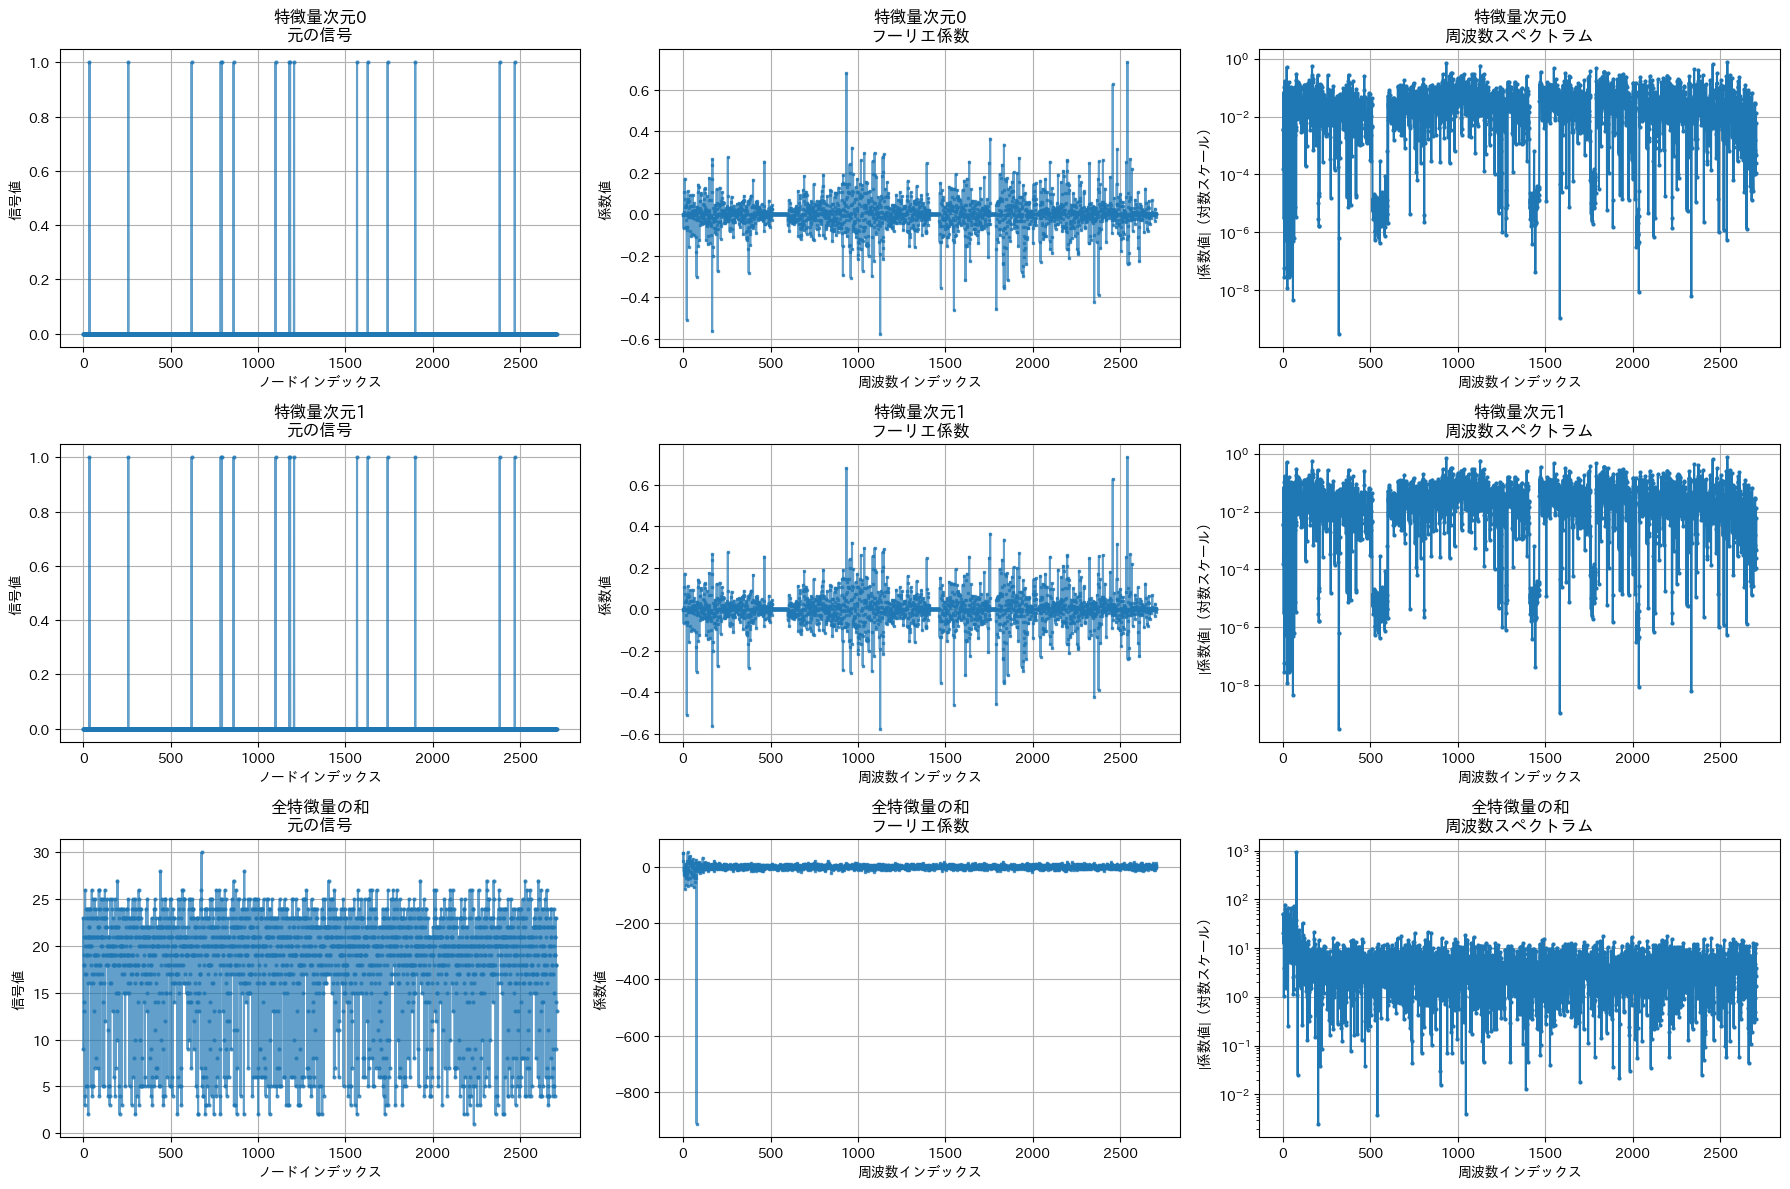

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib

# グラフフーリエ変換の基礎
print("=== グラフフーリエ変換の基礎 ===")

# Coraネットワークの実際の特徴量を使ってグラフ信号を作成
print("Coraデータセットの特徴量情報:")
print(f"ノード特徴量の形状: {data.x.shape}")
print(f"特徴量の次元数: {data.x.shape[1]}")

# 例1: 最初の特徴量次元を信号として使用
graph_signal_1 = data.x[:, 0]
print(f"\n信号1（特徴量次元0）の統計:")
print(f"  形状: {graph_signal_1.shape}")
print(f"  最小値: {graph_signal_1.min():.4f}")
print(f"  最大値: {graph_signal_1.max():.4f}")
print(f"  平均値: {graph_signal_1.mean():.4f}")

# 例2: 最初の特徴量次元を信号として使用
graph_signal_2 = data.x[:, 1]
print(f"\n信号2（特徴量次元1）の統計:")
print(f"  形状: {graph_signal_2.shape}")
print(f"  最小値: {graph_signal_2.min():.4f}")
print(f"  最大値: {graph_signal_2.max():.4f}")
print(f"  平均値: {graph_signal_2.mean():.4f}")

# 例3: すべての特徴量の和を信号として使用
graph_signal_3 = data.x.sum(dim=1)
print(f"\n信号3（全特徴量の和）の統計:")
print(f"  形状: {graph_signal_3.shape}")
print(f"  最小値: {graph_signal_3.min():.4f}")
print(f"  最大値: {graph_signal_3.max():.4f}")
print(f"  平均値: {graph_signal_3.mean():.4f}")

# 異なる信号のグラフフーリエ変換を比較
signals = {
    '特徴量次元0': graph_signal_1,
    '特徴量次元1': graph_signal_2,
    '全特徴量の和': graph_signal_3
}

plt.figure(figsize=(18, 12))

for i, (signal_name, signal) in enumerate(signals.items()):
    fourier_coeffs = U.T @ signal # グラフフーリエ変換: x̂ = U^T * x
    reconstructed = U @ fourier_coeffs # 逆グラフフーリエ変換: x = U * x̂

    # 再構成誤差を計算
    reconstruction_error = torch.max(torch.abs(signal - reconstructed))
    print(f"再構成誤差 {signal_name}: {reconstruction_error:.2e}")
    
    # 元の信号
    plt.subplot(3, 3, 3*i + 1)
    plt.plot(signal.numpy(), 'o-', markersize=2, alpha=0.7)
    plt.title(f'{signal_name}\n元の信号')
    plt.xlabel('ノードインデックス')
    plt.ylabel('信号値')
    plt.grid(True)
    
    # フーリエ係数
    plt.subplot(3, 3, 3*i + 2)
    plt.plot(fourier_coeffs.numpy(), 's-', markersize=2, alpha=0.7)
    plt.title(f'{signal_name}\nフーリエ係数')
    plt.xlabel('周波数インデックス')
    plt.ylabel('係数値')
    plt.grid(True)
    
    # 周波数スペクトラム（絶対値）
    plt.subplot(3, 3, 3*i + 3)
    plt.semilogy(torch.abs(fourier_coeffs).numpy(), 'o-', markersize=2)
    plt.title(f'{signal_name}\n周波数スペクトラム')
    plt.xlabel('周波数インデックス')
    plt.ylabel('|係数値|（対数スケール）')
    plt.grid(True)

plt.tight_layout()
plt.show()

=== グラフフィルタリングの実験 ===
フィルタリング結果:
  元信号のエネルギー: 16.000000
  低周波信号のエネルギー: 2.299700
  高周波信号のエネルギー: 2.515105
  中間周波数信号のエネルギー: 6.622666


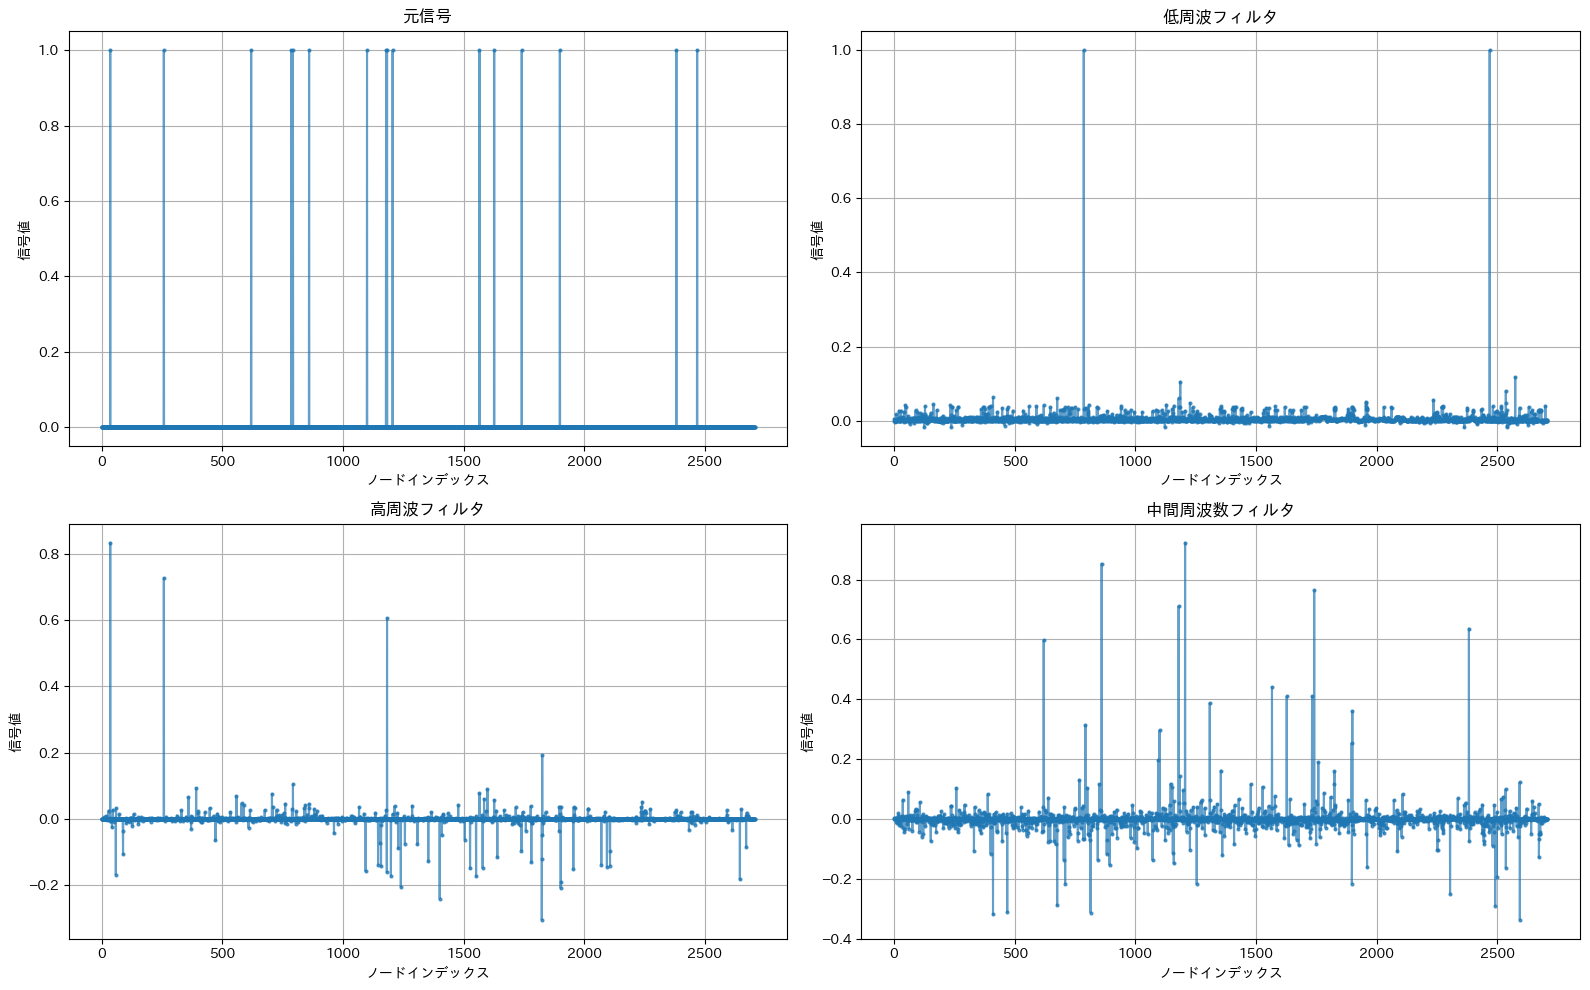


スムースネス比較:
  元信号: 0.011600
  低周波フィルタ: 0.001074
  高周波フィルタ: 0.014844
  中間周波数フィルタ: 0.017081

低周波フィルタは元信号より10.80倍スムース


In [30]:
# 低周波フィルタリングと高周波フィルタリングの実験
print("=== グラフフィルタリングの実験 ===")

signal_to_filter = graph_signal_1
fourier_coeffs = U.T @ signal_to_filter

# 低周波フィルタ（低い固有値に対応する係数のみを保持）
low_freq_cutoff = int(0.1 * len(fourier_coeffs))  # 下位10%の周波数のみ保持
low_pass_coeffs = fourier_coeffs.clone()
low_pass_coeffs[low_freq_cutoff:] = 0
low_pass_signal = U @ low_pass_coeffs

# 高周波フィルタ（高い固有値に対応する係数のみを保持）
high_freq_cutoff = int(0.9 * len(fourier_coeffs))  # 上位10%の周波数のみ保持
high_pass_coeffs = fourier_coeffs.clone()
high_pass_coeffs[:high_freq_cutoff] = 0
high_pass_signal = U @ high_pass_coeffs

# 中間周波数フィルタ
mid_low = int(0.3 * len(fourier_coeffs))
mid_high = int(0.7 * len(fourier_coeffs))
band_pass_coeffs = fourier_coeffs.clone()
band_pass_coeffs[:mid_low] = 0
band_pass_coeffs[mid_high:] = 0
band_pass_signal = U @ band_pass_coeffs

print(f"フィルタリング結果:")
print(f"  元信号のエネルギー: {torch.sum(signal_to_filter**2):.6f}")
print(f"  低周波信号のエネルギー: {torch.sum(low_pass_signal**2):.6f}")
print(f"  高周波信号のエネルギー: {torch.sum(high_pass_signal**2):.6f}")
print(f"  中間周波数信号のエネルギー: {torch.sum(band_pass_signal**2):.6f}")

# フィルタリング結果の可視化
plt.figure(figsize=(16, 10))

signals_to_plot = [
    ('元信号', signal_to_filter),
    ('低周波フィルタ', low_pass_signal),
    ('高周波フィルタ', high_pass_signal),
    ('中間周波数フィルタ', band_pass_signal)
]

for i, (name, signal) in enumerate(signals_to_plot):
    plt.subplot(2, 2, i+1)
    plt.plot(signal.numpy(), 'o-', markersize=2, alpha=0.7)
    plt.title(f'{name}')
    plt.xlabel('ノードインデックス')
    plt.ylabel('信号値')
    plt.grid(True)

plt.tight_layout()
plt.show()

# フィルタリングされた信号のスムースネスを比較
def calculate_smoothness(signal, edge_index):
    differences = []
    for i in range(edge_index.shape[1]):
        node1, node2 = edge_index[:, i]
        diff = abs(signal[node1] - signal[node2])
        differences.append(diff.item())
    return sum(differences) / len(differences)

smoothness_original = calculate_smoothness(signal_to_filter, train_data.edge_index)
smoothness_low = calculate_smoothness(low_pass_signal, train_data.edge_index)
smoothness_high = calculate_smoothness(high_pass_signal, train_data.edge_index)
smoothness_band = calculate_smoothness(band_pass_signal, train_data.edge_index)

print(f"\nスムースネス比較:")
print(f"  元信号: {smoothness_original:.6f}")
print(f"  低周波フィルタ: {smoothness_low:.6f}")
print(f"  高周波フィルタ: {smoothness_high:.6f}")
print(f"  中間周波数フィルタ: {smoothness_band:.6f}")
print(f"\n低周波フィルタは元信号より{smoothness_original/smoothness_low:.2f}倍スムース")

## ローパスフィルタと逆グラフフーリエ変換

ローパスフィルタ処理のステップを詳しく分析：
1. 元信号のグラフフーリエ変換
2. 低周波成分のみを保持（ローパスフィルタ）
3. 逆グラフフーリエ変換による信号再構成
4. 元信号と再構成信号の比較

In [31]:
# ローパスフィルタによる信号再構成の詳細分析
print("=== ローパスフィルタによる信号再構成の詳細分析 ===")

# 元信号を使用（特徴量次元0）
original_signal = graph_signal_1
print(f"元信号の統計:")
print(f"  信号長: {len(original_signal)}")
print(f"  最小値: {original_signal.min():.6f}")
print(f"  最大値: {original_signal.max():.6f}")
print(f"  平均値: {original_signal.mean():.6f}")
print(f"  標準偏差: {original_signal.std():.6f}")
print(f"  エネルギー: {torch.sum(original_signal**2):.6f}")

# ステップ1: グラフフーリエ変換
print(f"\n--- ステップ1: グラフフーリエ変換 ---")
fourier_coeffs = U.T @ original_signal
print(f"フーリエ係数の形状: {fourier_coeffs.shape}")
print(f"フーリエ係数のエネルギー: {torch.sum(fourier_coeffs**2):.6f}")

# 異なるカットオフ周波数でのローパスフィルタ実験
cutoff_percentages = [0.05, 0.1, 0.2, 0.3, 0.5]
reconstruction_results = {}

for cutoff_pct in cutoff_percentages:
    # ステップ2: ローパスフィルタ適用
    cutoff_index = int(cutoff_pct * len(fourier_coeffs))
    filtered_coeffs = fourier_coeffs.clone()
    filtered_coeffs[cutoff_index:] = 0  # 高周波成分をゼロに
    
    # ステップ3: 逆グラフフーリエ変換
    reconstructed_signal = U @ filtered_coeffs
    
    # ステップ4: 分析
    reconstruction_error = torch.sqrt(torch.sum((original_signal - reconstructed_signal)**2))
    relative_error = reconstruction_error / torch.sqrt(torch.sum(original_signal**2))
    energy_preserved = torch.sum(filtered_coeffs**2) / torch.sum(fourier_coeffs**2)
    
    reconstruction_results[cutoff_pct] = {
        'signal': reconstructed_signal,
        'coeffs': filtered_coeffs,
        'error': reconstruction_error,
        'relative_error': relative_error,
        'energy_preserved': energy_preserved,
        'cutoff_index': cutoff_index
    }
    
    print(f"\nカットオフ {cutoff_pct*100:.0f}% ({cutoff_index}個の低周波成分保持):")
    print(f"  再構成誤差: {reconstruction_error:.6f}")
    print(f"  相対誤差: {relative_error:.6f}")
    print(f"  保持エネルギー比: {energy_preserved:.6f}")
    
print(f"\n元信号と完全再構成の検証:")
full_reconstruction = U @ fourier_coeffs
full_error = torch.max(torch.abs(original_signal - full_reconstruction))
print(f"完全再構成誤差: {full_error:.2e}")

=== ローパスフィルタによる信号再構成の詳細分析 ===
元信号の統計:
  信号長: 2708
  最小値: 0.000000
  最大値: 1.000000
  平均値: 0.005908
  標準偏差: 0.076653
  エネルギー: 16.000000

--- ステップ1: グラフフーリエ変換 ---
フーリエ係数の形状: torch.Size([2708])
フーリエ係数のエネルギー: 16.000006

カットオフ 5% (135個の低周波成分保持):
  再構成誤差: 3.847038
  相対誤差: 0.961759
  保持エネルギー比: 0.075019

カットオフ 10% (270個の低周波成分保持):
  再構成誤差: 3.701392
  相対誤差: 0.925348
  保持エネルギー比: 0.143731

カットオフ 20% (541個の低周波成分保持):
  再構成誤差: 3.548035
  相対誤差: 0.887009
  保持エネルギー比: 0.213215

カットオフ 30% (812個の低周波成分保持):
  再構成誤差: 3.370182
  相対誤差: 0.842546
  保持エネルギー比: 0.290117

カットオフ 50% (1354個の低周波成分保持):
  再構成誤差: 2.901424
  相対誤差: 0.725356
  保持エネルギー比: 0.473859

元信号と完全再構成の検証:
完全再構成誤差: 7.15e-07


=== ローパスフィルタ結果の可視化 ===


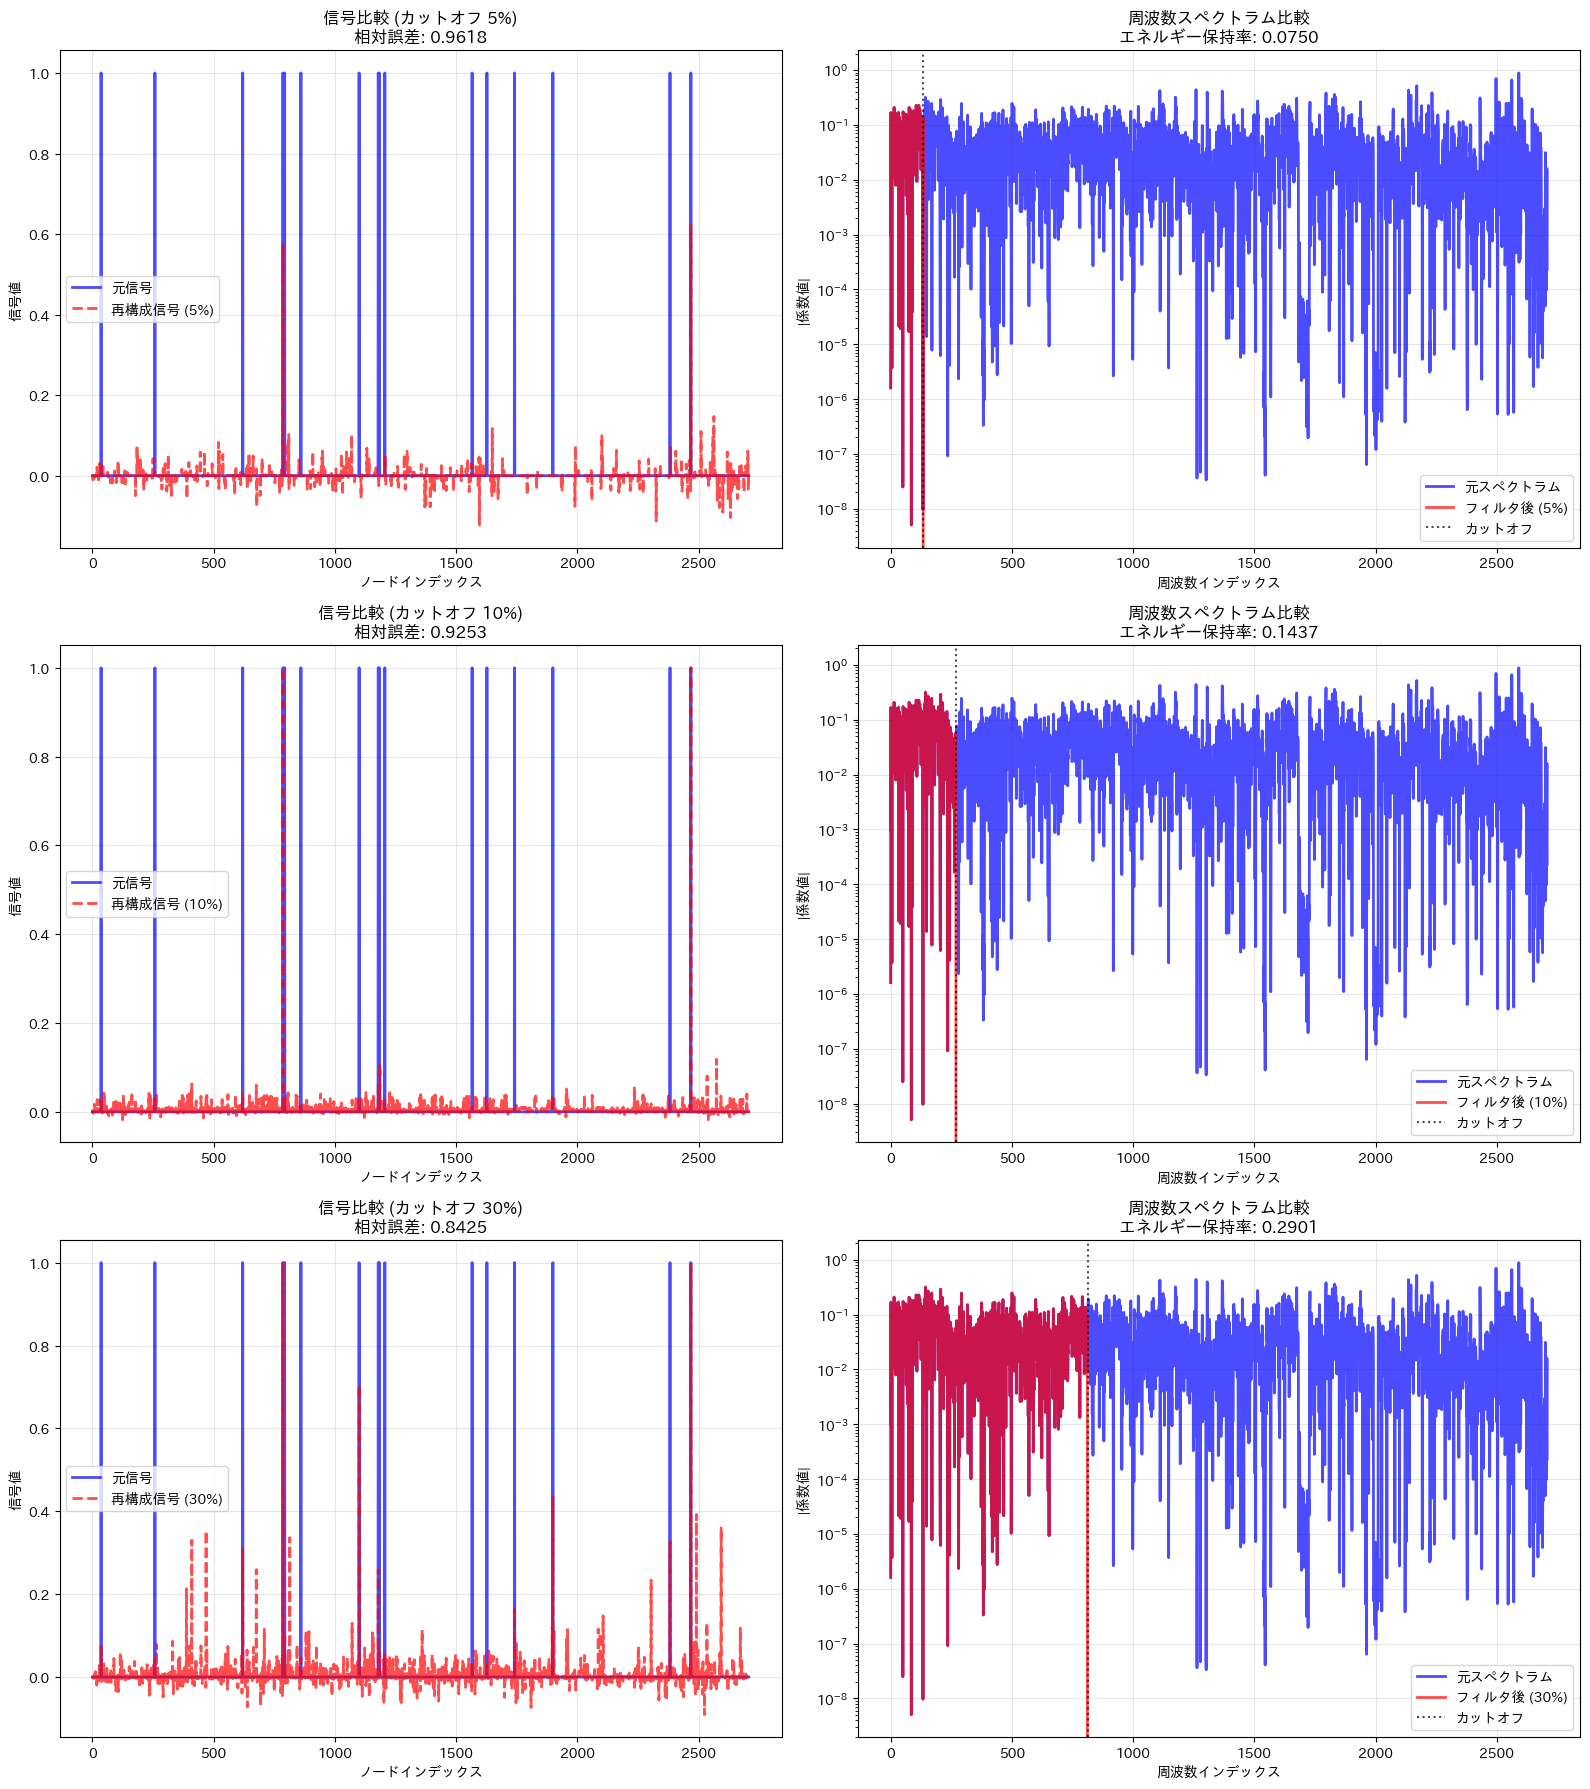

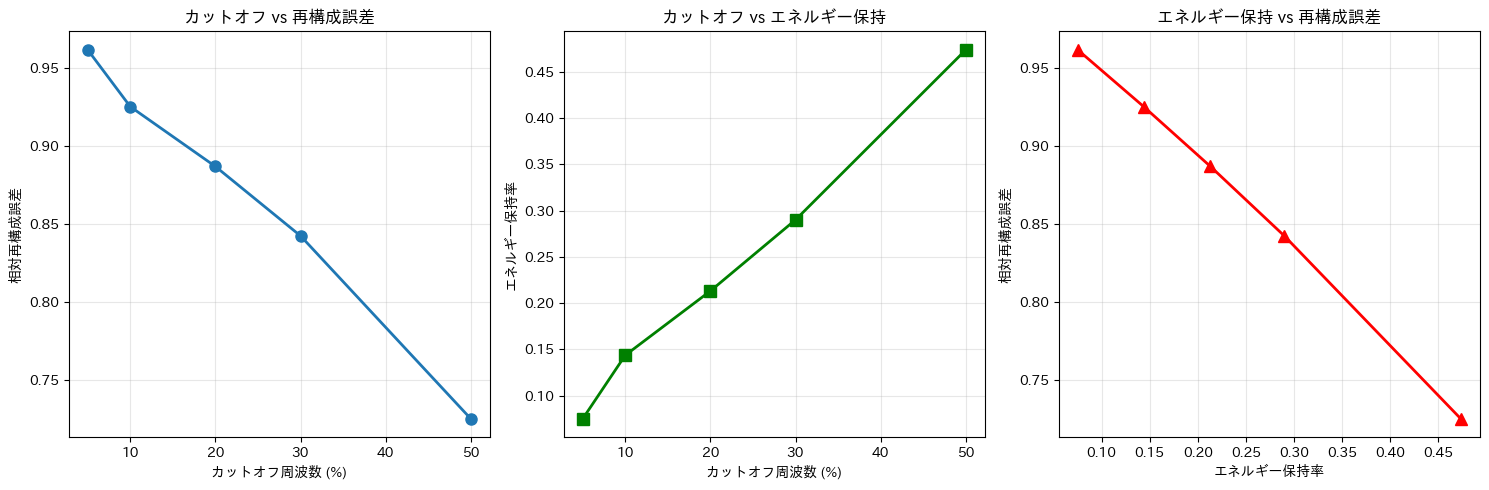

In [32]:
# ローパスフィルタ結果の詳細可視化
print("=== ローパスフィルタ結果の可視化 ===")

fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 選択的に3つのカットオフを詳細表示
selected_cutoffs = [0.05, 0.1, 0.3]

for i, cutoff_pct in enumerate(selected_cutoffs):
    result = reconstruction_results[cutoff_pct]
    
    # 元信号 vs 再構成信号
    axes[i, 0].plot(original_signal.numpy(), 'b-', alpha=0.7, label='元信号', linewidth=2)
    axes[i, 0].plot(result['signal'].numpy(), 'r--', alpha=0.7, label=f'再構成信号 ({cutoff_pct*100:.0f}%)', linewidth=2)
    axes[i, 0].set_title(f'信号比較 (カットオフ {cutoff_pct*100:.0f}%)\n相対誤差: {result["relative_error"]:.4f}')
    axes[i, 0].set_xlabel('ノードインデックス')
    axes[i, 0].set_ylabel('信号値')
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # フーリエ係数の比較
    axes[i, 1].plot(torch.abs(fourier_coeffs).numpy(), 'b-', alpha=0.7, label='元スペクトラム', linewidth=2)
    axes[i, 1].plot(torch.abs(result['coeffs']).numpy(), 'r-', alpha=0.7, label=f'フィルタ後 ({cutoff_pct*100:.0f}%)', linewidth=2)
    axes[i, 1].axvline(x=result['cutoff_index'], color='k', linestyle=':', alpha=0.7, label='カットオフ')
    axes[i, 1].set_title(f'周波数スペクトラム比較\nエネルギー保持率: {result["energy_preserved"]:.4f}')
    axes[i, 1].set_xlabel('周波数インデックス')
    axes[i, 1].set_ylabel('|係数値|')
    axes[i, 1].set_yscale('log')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 誤差とエネルギー保持率の関係を可視化
plt.figure(figsize=(15, 5))

cutoffs = list(reconstruction_results.keys())
errors = [reconstruction_results[c]['relative_error'].item() for c in cutoffs]
energy_ratios = [reconstruction_results[c]['energy_preserved'].item() for c in cutoffs]

plt.subplot(1, 3, 1)
plt.plot([c*100 for c in cutoffs], errors, 'o-', linewidth=2, markersize=8)
plt.xlabel('カットオフ周波数 (%)')
plt.ylabel('相対再構成誤差')
plt.title('カットオフ vs 再構成誤差')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot([c*100 for c in cutoffs], energy_ratios, 's-', linewidth=2, markersize=8, color='green')
plt.xlabel('カットオフ周波数 (%)')
plt.ylabel('エネルギー保持率')
plt.title('カットオフ vs エネルギー保持')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(energy_ratios, errors, '^-', linewidth=2, markersize=8, color='red')
plt.xlabel('エネルギー保持率')
plt.ylabel('相対再構成誤差')
plt.title('エネルギー保持 vs 再構成誤差')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== スムースネス分析とローパスフィルタの効果 ===
元信号のスムースネス統計:
  平均差分: 0.011600
  差分の標準偏差: 0.107085
  最大差分: 1.000000
  最小差分: 0.000000
  中央値: 0.000000

カットオフ 5%のスムースネス:
  平均差分: 0.000000
  差分の標準偏差: 0.000000
  スムースネス改善倍率: 255157.64x

カットオフ 10%のスムースネス:
  平均差分: 0.001074
  差分の標準偏差: 0.001862
  スムースネス改善倍率: 10.80x

カットオフ 5%のスムースネス:
  平均差分: 0.000000
  差分の標準偏差: 0.000000
  スムースネス改善倍率: 255157.64x

カットオフ 10%のスムースネス:
  平均差分: 0.001074
  差分の標準偏差: 0.001862
  スムースネス改善倍率: 10.80x

カットオフ 20%のスムースネス:
  平均差分: 0.004510
  差分の標準偏差: 0.010150
  スムースネス改善倍率: 2.57x

カットオフ 30%のスムースネス:
  平均差分: 0.006747
  差分の標準偏差: 0.018573
  スムースネス改善倍率: 1.72x

カットオフ 20%のスムースネス:
  平均差分: 0.004510
  差分の標準偏差: 0.010150
  スムースネス改善倍率: 2.57x

カットオフ 30%のスムースネス:
  平均差分: 0.006747
  差分の標準偏差: 0.018573
  スムースネス改善倍率: 1.72x

カットオフ 50%のスムースネス:
  平均差分: 0.010255
  差分の標準偏差: 0.036980
  スムースネス改善倍率: 1.13x

カットオフ 50%のスムースネス:
  平均差分: 0.010255
  差分の標準偏差: 0.036980
  スムースネス改善倍率: 1.13x


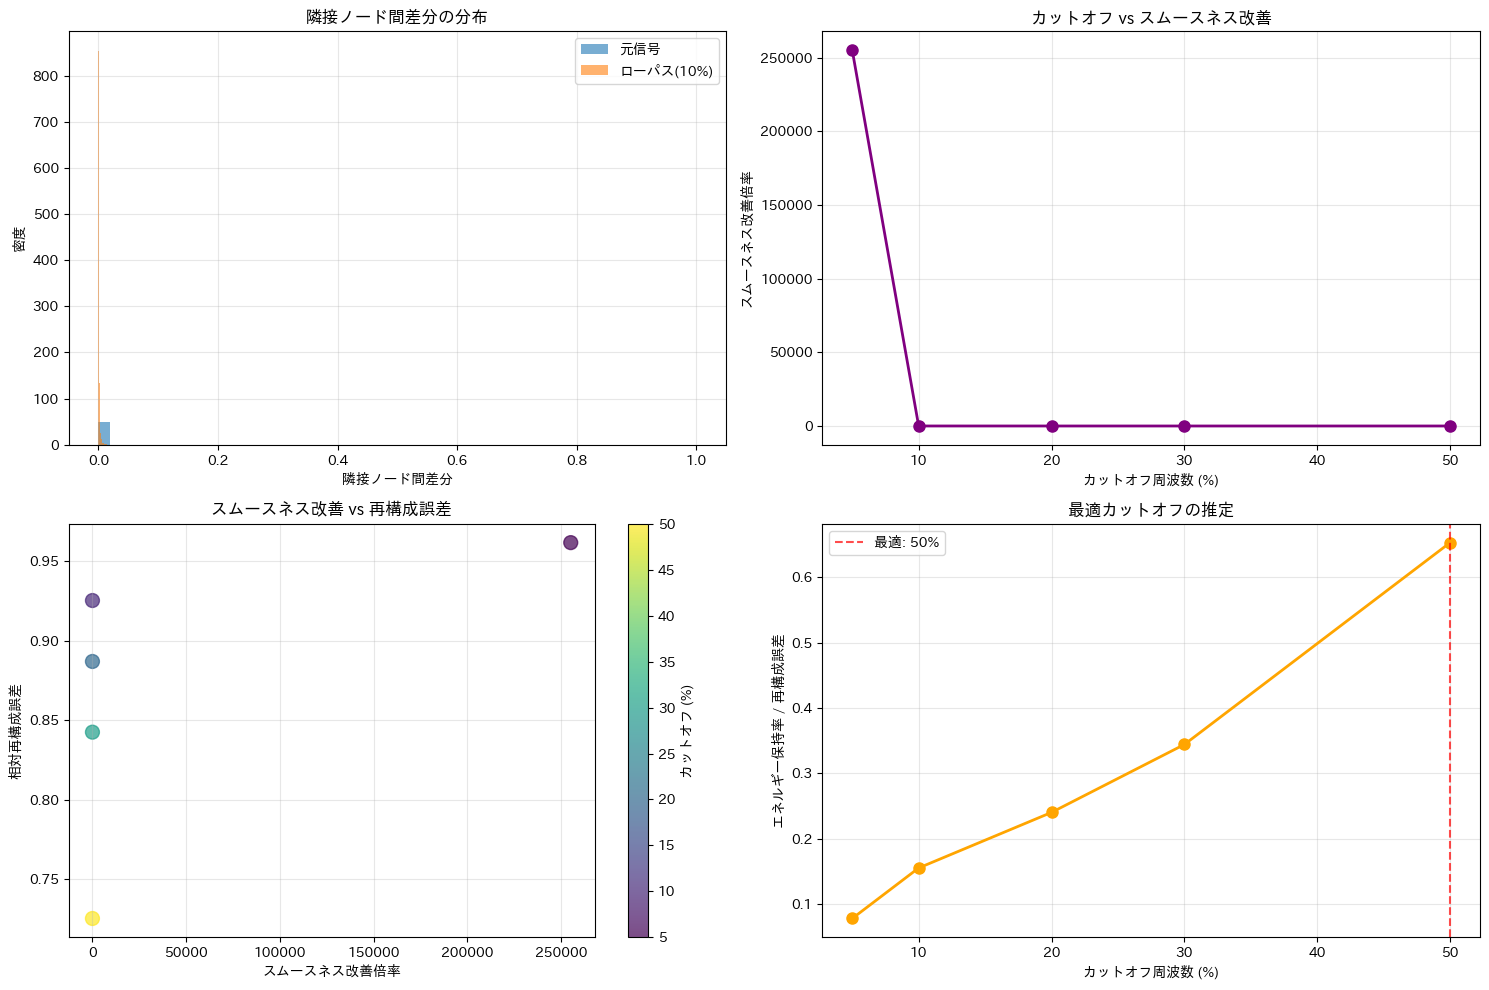


=== 最適化結果 ===
推奨カットオフ: 50%
  相対再構成誤差: 0.725356
  エネルギー保持率: 0.473859
  スムースネス改善倍率: 1.13x


In [33]:
# スムースネスとローパスフィルタの効果を定量分析
print("=== スムースネス分析とローパスフィルタの効果 ===")

def calculate_detailed_smoothness(signal, edge_index):
    """隣接ノード間の差分を詳しく分析"""
    differences = []
    for i in range(edge_index.shape[1]):
        node1, node2 = edge_index[:, i]
        diff = abs(signal[node1] - signal[node2])
        differences.append(diff.item())
    
    differences = torch.tensor(differences)
    return {
        'mean': differences.mean().item(),
        'std': differences.std().item(),
        'max': differences.max().item(),
        'min': differences.min().item(),
        'median': differences.median().item()
    }

# 元信号のスムースネス分析
original_smoothness = calculate_detailed_smoothness(original_signal, train_data.edge_index)
print(f"元信号のスムースネス統計:")
print(f"  平均差分: {original_smoothness['mean']:.6f}")
print(f"  差分の標準偏差: {original_smoothness['std']:.6f}")
print(f"  最大差分: {original_smoothness['max']:.6f}")
print(f"  最小差分: {original_smoothness['min']:.6f}")
print(f"  中央値: {original_smoothness['median']:.6f}")

# 各カットオフでのスムースネス分析
smoothness_results = {}
for cutoff_pct in cutoff_percentages:
    reconstructed = reconstruction_results[cutoff_pct]['signal']
    smoothness = calculate_detailed_smoothness(reconstructed, train_data.edge_index)
    smoothness_results[cutoff_pct] = smoothness
    
    improvement_factor = original_smoothness['mean'] / smoothness['mean']
    print(f"\nカットオフ {cutoff_pct*100:.0f}%のスムースネス:")
    print(f"  平均差分: {smoothness['mean']:.6f}")
    print(f"  差分の標準偏差: {smoothness['std']:.6f}")
    print(f"  スムースネス改善倍率: {improvement_factor:.2f}x")

# スムースネス改善の可視化
plt.figure(figsize=(15, 10))

# 隣接ノード間差分の分布比較
plt.subplot(2, 2, 1)
original_diffs = []
low_pass_diffs = []
for i in range(train_data.edge_index.shape[1]):
    node1, node2 = train_data.edge_index[:, i]
    orig_diff = abs(original_signal[node1] - original_signal[node2])
    filtered_diff = abs(reconstruction_results[0.1]['signal'][node1] - reconstruction_results[0.1]['signal'][node2])
    original_diffs.append(orig_diff.item())
    low_pass_diffs.append(filtered_diff.item())

plt.hist(original_diffs, bins=50, alpha=0.6, label='元信号', density=True)
plt.hist(low_pass_diffs, bins=50, alpha=0.6, label='ローパス(10%)', density=True)
plt.xlabel('隣接ノード間差分')
plt.ylabel('密度')
plt.title('隣接ノード間差分の分布')
plt.legend()
plt.grid(True, alpha=0.3)

# スムースネス改善倍率 vs カットオフ
plt.subplot(2, 2, 2)
cutoffs = list(smoothness_results.keys())
improvements = [original_smoothness['mean'] / smoothness_results[c]['mean'] for c in cutoffs]
plt.plot([c*100 for c in cutoffs], improvements, 'o-', linewidth=2, markersize=8, color='purple')
plt.xlabel('カットオフ周波数 (%)')
plt.ylabel('スムースネス改善倍率')
plt.title('カットオフ vs スムースネス改善')
plt.grid(True, alpha=0.3)

# 再構成誤差 vs スムースネス改善のトレードオフ
plt.subplot(2, 2, 3)
plt.scatter(improvements, errors, s=100, alpha=0.7, c=[c*100 for c in cutoffs], cmap='viridis')
plt.xlabel('スムースネス改善倍率')
plt.ylabel('相対再構成誤差')
plt.title('スムースネス改善 vs 再構成誤差')
plt.colorbar(label='カットオフ (%)')
plt.grid(True, alpha=0.3)

# 最適なカットオフの提案
plt.subplot(2, 2, 4)
# トレードオフ指標: エネルギー保持率 / 再構成誤差
tradeoff_scores = [energy_ratios[i] / errors[i] for i in range(len(cutoffs))]
optimal_idx = tradeoff_scores.index(max(tradeoff_scores))
optimal_cutoff = cutoffs[optimal_idx]

plt.plot([c*100 for c in cutoffs], tradeoff_scores, 'o-', linewidth=2, markersize=8, color='orange')
plt.axvline(x=optimal_cutoff*100, color='red', linestyle='--', alpha=0.7, label=f'最適: {optimal_cutoff*100:.0f}%')
plt.xlabel('カットオフ周波数 (%)')
plt.ylabel('エネルギー保持率 / 再構成誤差')
plt.title('最適カットオフの推定')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== 最適化結果 ===")
print(f"推奨カットオフ: {optimal_cutoff*100:.0f}%")
print(f"  相対再構成誤差: {reconstruction_results[optimal_cutoff]['relative_error']:.6f}")
print(f"  エネルギー保持率: {reconstruction_results[optimal_cutoff]['energy_preserved']:.6f}")
print(f"  スムースネス改善倍率: {original_smoothness['mean'] / smoothness_results[optimal_cutoff]['mean']:.2f}x")